In [1]:
import os
import random

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import re
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Tuple

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
import torchvision.transforms as T
import sklearn.utils as utils

In [2]:
torch.cuda.empty_cache()
random_seed = 42
batch_size = 50
train_root = 'train_images'
NUM_EPOCHS = 15
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train_table = pd.read_csv('train.csv')
train_table.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
train_table.shape

(21396, 2)

In [5]:
train_table['label'].value_counts()

3    13158
4     2576
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [6]:
train_paths = [os.path.join(train_root, file) for file in train_table['image_id']]
train_labels = train_table['label'].values

In [7]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

def default_loader(path):
    img_pil =  Image.open(path)
    img_pil = img_pil.resize((224,224))
    img_tensor = preprocess(img_pil)
    return img_tensor

C:\Users\woqip\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [8]:
class MyDataset(Dataset):
    def __init__(self, img_paths, labels, loader=default_loader):
        self.img_paths = img_paths
        self.labels = labels
        self.loader = loader
        
    def __getitem__(self, index):
        img_path, label = self.img_paths[index], self.labels[index]
        img = self.loader(img_path)
        
        return img, label
    
    def __len__(self):
        return len(self.labels)

In [9]:
dataset = MyDataset(train_paths, train_labels)
len(dataset)*np.array([0.8,0.05,0.15])

array([17116.8,  1069.8,  3209.4])

In [10]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [17000 ,  1070,  3326], generator=torch.Generator().manual_seed(random_seed))

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)
model = model.to(device)

Using cache found in C:\Users\woqip/.cache\torch\hub\pytorch_vision_v0.9.0


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

Epoch: 001/015 | Batch 0000/0340 | Loss: 7.7670
Epoch: 001/015 | Batch 0100/0340 | Loss: 1.0785
Epoch: 001/015 | Batch 0200/0340 | Loss: 0.5602
Epoch: 001/015 | Batch 0300/0340 | Loss: 0.6413
Epoch: 001/015 | Train: 86.17% | Validation: 80.00%
Time elapsed: 6.91 min
Epoch: 002/015 | Batch 0000/0340 | Loss: 0.5399
Epoch: 002/015 | Batch 0100/0340 | Loss: 0.5781
Epoch: 002/015 | Batch 0200/0340 | Loss: 0.2608
Epoch: 002/015 | Batch 0300/0340 | Loss: 0.3648
Epoch: 002/015 | Train: 94.36% | Validation: 81.50%
Time elapsed: 13.76 min
Epoch: 003/015 | Batch 0000/0340 | Loss: 0.2720
Epoch: 003/015 | Batch 0100/0340 | Loss: 0.1645
Epoch: 003/015 | Batch 0200/0340 | Loss: 0.1208
Epoch: 003/015 | Batch 0300/0340 | Loss: 0.1472
Epoch: 003/015 | Train: 98.38% | Validation: 79.72%
Time elapsed: 20.65 min
Epoch: 004/015 | Batch 0000/0340 | Loss: 0.0433
Epoch: 004/015 | Batch 0100/0340 | Loss: 0.0309
Epoch: 004/015 | Batch 0200/0340 | Loss: 0.0258
Epoch: 004/015 | Batch 0300/0340 | Loss: 0.0144
Epoch

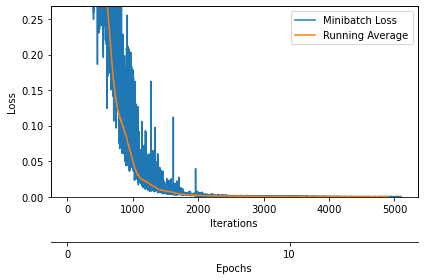

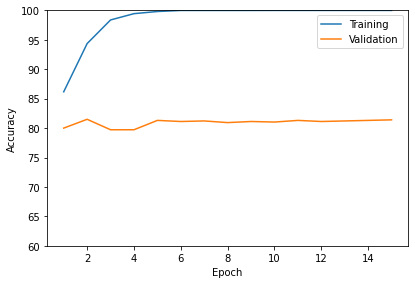

In [14]:

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [15]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  105948 KB |    2808 MB |   67159 GB |   67159 GB |
|       from large pool |   58432 KB |    2755 MB |   66766 GB |   66766 GB |
|       from small pool |   47516 KB |      53 MB |     392 GB |     392 GB |
|---------------------------------------------------------------------------|
| Active memory         |  105948 KB |    2808 MB |   67159 GB |   67159 GB |
|       from large pool |   58432 KB |    2755 MB |   66766 GB |

In [16]:
torch.cuda.empty_cache()